# Comparing H3 cells to administrative boundaries

The fundamental process of the Space2Stats program is to calculate zonal statistics on foundational geospatial data at a standard, global hexagon grid, and then aggregate that grid to the administrative boundaries.

This notebook focuses on exploring the intersection of the [H3 grids](https://h3geo.org/) with the official, high-resolution World Bank administrative boundaries.

In [12]:
import sys, os, importlib, math, multiprocessing
import rasterio, geojson

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from h3 import h3
from tqdm import tqdm

import GOSTRocks.rasterMisc as rMisc
from GOSTRocks.misc import tPrint

sys.path.append("../src")
import h3_helper
import country_zonal

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
admin_bounds = "/home/public/Data/GLOBAL/ADMIN/ADMIN2/HighRes_20230328/shp/WB_GAD_ADM2.shp"
sel_iso3 = "UGA"
out_folder = f"/home/wb411133/projects/Space2Stats/"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
    
h3_level = 6

In [4]:
inA = gpd.read_file(admin_bounds)

In [5]:
# run all of Africa at once
afr_iso3 = inA.loc[inA['WB_REGION'] == 'AFR', "ISO_A3"].values
afr_iso3 = list(set(afr_iso3))

args = []
for iso3 in afr_iso3:
    selA = inA.loc[inA['ISO_A3'] == iso3].copy()
    cur_out = os.path.join(out_folder, iso3)
    if not os.path.exists(cur_out):
        os.makedirs(cur_out)
    args.append([iso3, selA, cur_out])

In [6]:
# for each country in Africa, calcluate the number of level 6 h3 hexabins in each admin3 region
#     intersection is performed on hexabin centroid

def run_mp(sel_iso3, selA, out_folder):
    h3_generator = country_zonal.country_h3_zonal(sel_iso3, selA, "GAUL_2", 6, out_folder)
    h3_res = h3_generator.generate_h3_grid(cols_to_include=["NAM_1", "NAM_2"])
    adm_res = h3_generator.summarize_adm_h3_join(verbose=True)
    h3_generator.write_output(write_h3=True, write_admin=True)
    return(adm_res)
    
    
''' This worked well to generate the data, but kept hanging when looking for summary results
with multiprocessing.Pool(len(args)) as pool:
    res = pool.starmap(run_mp, args)
'''
all_res = []
for arg in args:
    res = run_mp(*arg)
    all_res.append(res)
    
'''
1. Number of h3 cells
2. Number of adm bounds
3. Number of adm bounds with 0 h3 centroids
4. Number of adm bounds with 0 - 1 h3 centroids
5. Number of adm bounds with 2 - 5 h3 centroids    
''' 

08:49:27	UGA: H3 [6178], ADM [170], ADM0 [6], ADM1 [11], ADM2 [2]
08:49:33	BWA: H3 [14013], ADM [10], ADM0 [0], ADM1 [0], ADM2 [0]
08:49:38	ERI: H3 [3319], ADM [58], ADM0 [2], ADM1 [2], ADM2 [1]
08:49:40	CPV: H3 [113], ADM [22], ADM0 [4], ADM1 [4], ADM2 [5]
08:49:42	MRT: H3 [28833], ADM [44], ADM0 [0], ADM1 [0], ADM2 [0]
08:49:49	SOM: H3 [20018], ADM [74], ADM0 [0], ADM1 [0], ADM2 [0]
08:49:55	NER: H3 [31228], ADM [67], ADM0 [0], ADM1 [0], ADM2 [0]
08:50:04	CAF: H3 [17441], ADM [71], ADM0 [0], ADM1 [1], ADM2 [0]
08:50:10	MUS: H3 [50], ADM [10], ADM0 [0], ADM1 [1], ADM2 [4]
08:50:11	GAB: H3 [7503], ADM [48], ADM0 [0], ADM1 [0], ADM2 [0]
08:50:15	SWZ: H3 [436], ADM [53], ADM0 [0], ADM1 [2], ADM2 [16]
08:50:18	NGA: H3 [27292], ADM [775], ADM0 [7], ADM1 [21], ADM2 [95]
08:50:27	CIV: H3 [12305], ADM [33], ADM0 [0], ADM1 [0], ADM2 [0]
08:50:33	KEN: H3 [15251], ADM [290], ADM0 [0], ADM1 [0], ADM2 [0]
08:50:38	LBR: H3 [3622], ADM [136], ADM0 [0], ADM1 [0], ADM2 [0]
08:50:42	ZWE: H3 [9151], ADM

In [17]:
all_res = pd.DataFrame(all_res, columns=['n_H3', 'n_ADM', 'n_ADM0', 'n_ADM1', 'n_ADM2'])
all_res['iso3'] = afr_iso3
all_res.to_csv(os.path.join(out_folder, "H3_admin_summary.csv"))

# Mapping

In [10]:
# generate map for NGA
def map_country(sel_iso3, legend_loc="lower right"):
    selA = inA.loc[inA['ISO_A3'] == sel_iso3].copy()
    cur_folder = os.path.join(out_folder, sel_iso3)
    h3_generator = country_zonal.country_h3_zonal(sel_iso3, selA, "GAUL_2", 6, cur_folder)
    cMap = h3_helper.map_choropleth(h3_generator.adm_bounds_h3, "h3_count", legend_loc=legend_loc)
    plt.title(f"{sel_iso3} count of intersecting h3 cells")
    return(cMap)

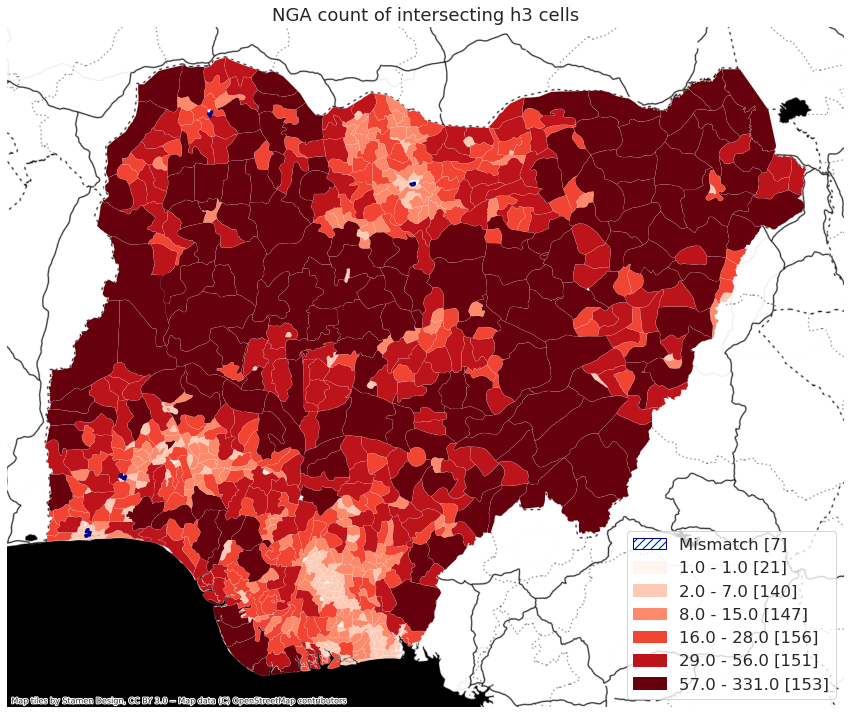

In [13]:
map_country("NGA")

/home/wb411133/.conda/envs/ee/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


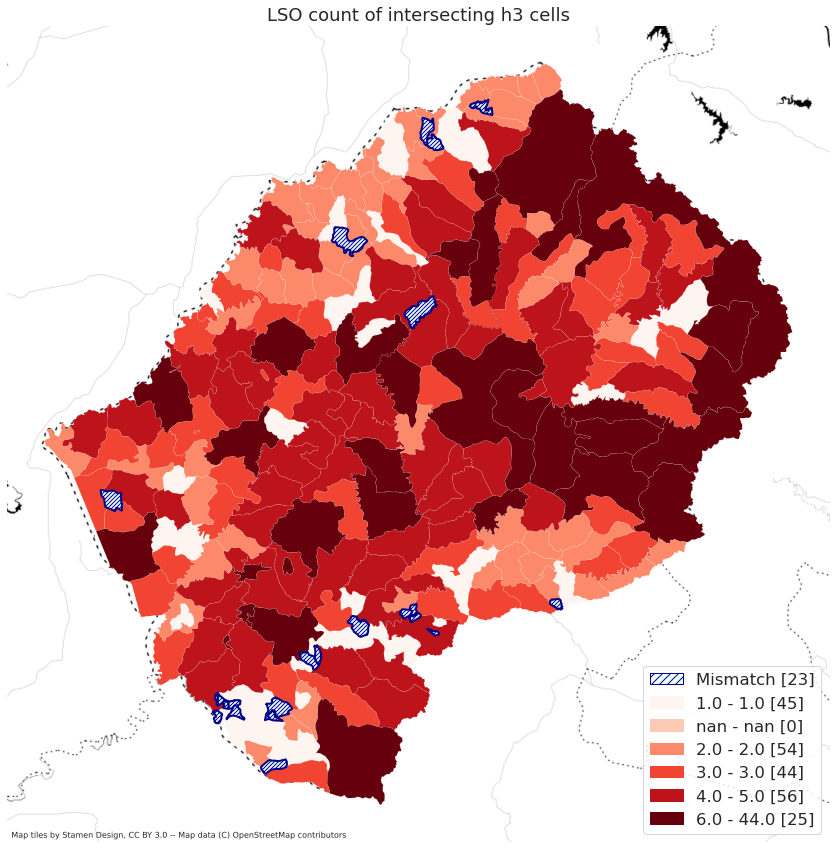

In [14]:
map_country("LSO")

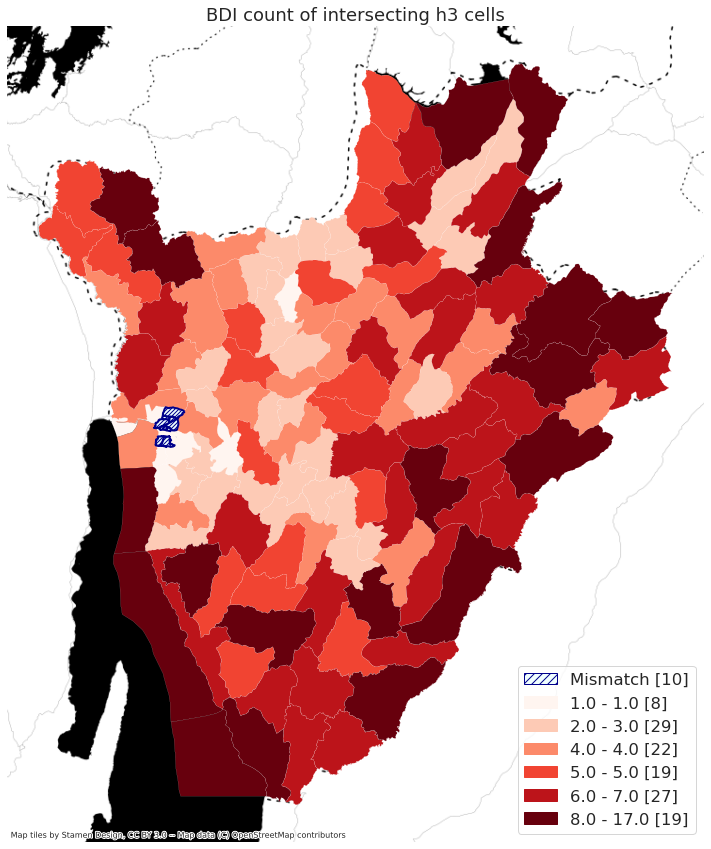

In [15]:
map_country("BDI")

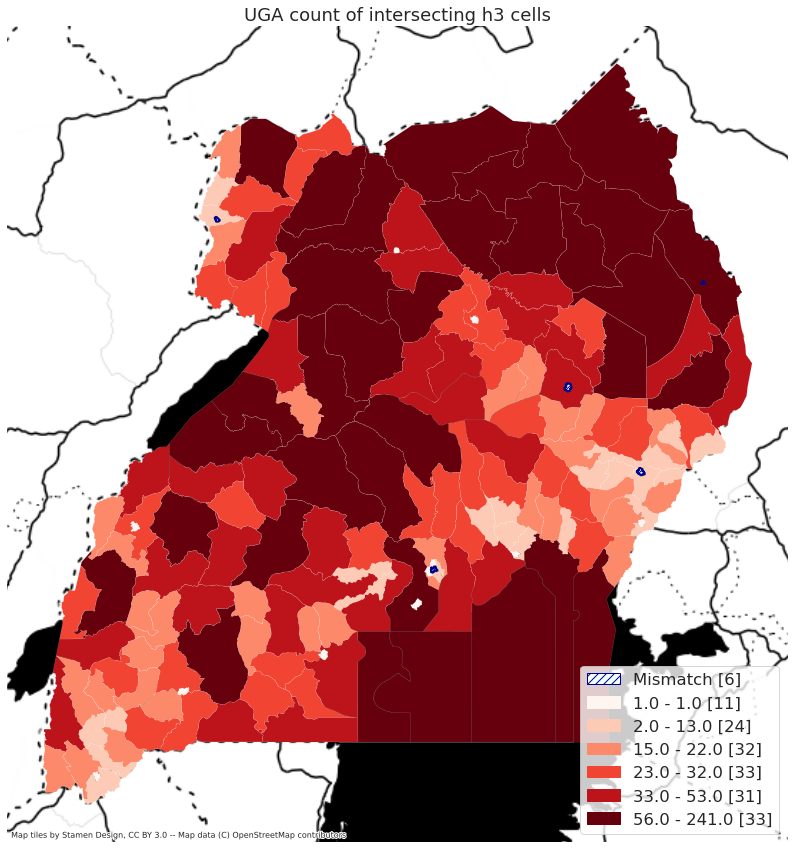

In [16]:
map_country('UGA')